<a href="https://colab.research.google.com/github/akshaydp1995/Deep-Reinforcement-Learning/blob/master/Blackjack_Monte_Carlo_with_Output.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Libraries
##### OpenAI's Gym toolkit has a lot of built-in environments

In [0]:
import gym
import numpy as np
from collections import defaultdict

## Create the Blackjack Environment
##### Print the State Space, Action Space, Reward Range, Discount Factor

In [2]:
# Create an environment using OpenAI's Gym Toolkit

env = gym.make('Blackjack-v0')   # Create an environment
gamma = 0.9

print("Observation Space  :", env.observation_space)     # State Space
print("Action Space       :", env.action_space)          # Action Space
print("Reward Range       :", env.reward_range)          # Reward Range
print("Discount Factor    :", gamma)                     # Discount Factor

Observation Space  : Tuple(Discrete(32), Discrete(11), Discrete(2))
Action Space       : Discrete(2)
Reward Range       : (-inf, inf)
Discount Factor    : 0.9


## Generate an episode - Equiprobable Random Policy
##### Select an action with equal probability for any state 
##### Generating a single episode (state, action, reward)

In [3]:
## Episodic Task - Use Monte Carlo Method to create an episode

def generate_episode_erp(): 
    episode = []
    state = env.reset()
    done = 0
    while True:
        probs = [0.5, 0.5]                                   # Policy
        action = np.random.choice([0, 1], p = probs)
        next_state, reward, done, info = env.step(action)    # Take an action
        episode.append((state, action, reward))
        state = next_state
        if done == 1: 
            break
    return episode

generate_episode_erp()

[((16, 9, False), 1, 0), ((21, 9, False), 0, 1.0)]

## Generate an episode - 'Policy number 1' (80% when sum > 18)
##### Policy - Take an action "Stick" with 80% probability when sum of cards > 18 
##### Generating a single episode (state, action, reward)

In [4]:
## Episodic Task - Use Monte Carlo Method to create an episode

def generate_episode_18(): 
    episode = []
    state = env.reset()
    done = 0
    while True:
        probs = [0.8, 0.2] if state[0] > 18 else [0.2, 0.8]  # Policy
        action = np.random.choice([0, 1], p = probs)
        next_state, reward, done, info = env.step(action)    # Take an action
        episode.append((state, action, reward))
        state = next_state
        if done == 1: 
            break
    return episode

generate_episode_18()

[((11, 7, False), 1, 0), ((21, 7, False), 0, 1.0)]

## Generate an episode - for any policy Q (greedy policy)
##### Input a policy Q 
##### Generating a single episode using the input policy Q 

In [5]:
def generate_episode_fv_policy(Q): 
    episode = []
    state = env.reset()
    done = 0
    while True:
        prob = [0, 1] if np.argmax(Q[state])==1 else [1, 0]
        action = np.random.choice([0, 1], p = prob)
        next_state, reward, done, info = env.step(action)    # Take an action
        episode.append((state, action, reward))
        state = next_state
        if done == 1: 
            break
    return episode
  
Q = defaultdict(lambda: np.zeros(2))                         # Random policy to check if function works
generate_episode_fv_policy(Q) 

[((20, 10, False), 0, 1.0)]

## Generate an episode - for any policy Q (epsilon-greedy policy)
##### Input epsilon value
##### probs() - Input is epsilon, Q and state - Output is the new action-value function for that particular state
##### Generating an episode with a particular epsilon and a particular input policy Q

In [6]:
def probs(epsilon, Q, state): 
    maxx = np.argmax(Q[state])
    Q[state] = [epsilon/2, epsilon/2]
    Q[state][maxx] = 1 - epsilon + (epsilon/2)

def generate_episode_fv_policy(epsilon, Q): 
    episode = []
    state = env.reset()
    done = 0
    while True:
        prob = probs(epsilon, Q, state)
        action = np.random.choice([0, 1], p = prob)
        next_state, reward, done, info = env.step(action)    # Take an action
        episode.append((state, action, reward))
        state = next_state
        if done == 1: 
            break
    return episode
  
Q = defaultdict(lambda: np.zeros(2))                         # Random policy to check if function works
epsilon = 0.9  
generate_episode_fv_policy(epsilon, Q)

[((16, 10, False), 1, -1)]

## Fill the Q-table

##### First-visit prediction with equiprobable random policy

In [7]:
# Function to evaluate policy using first-visit MC

def policy_evaluation_fv_erp(number_episodes = 1): 
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    summ = defaultdict(lambda: np.zeros(env.action_space.n))
    N = defaultdict(lambda: np.zeros(env.action_space.n))
    for _ in range(number_episodes): 
        states, actions, rewards = zip(*generate_episode_erp())
        states_all = []
        for index, state in enumerate(states): 
            if state not in states_all: 
                summ[state][actions[index]] = sum([(gamma)**i for i in range(len(rewards))][::-1][::-1]*np.asarray(rewards))
                N[state][actions[index]] += 1
            Q[state][actions[index]] = summ[state][actions[index]] / N[state][actions[index]]
            states_all.append(state)
    return Q
                
policy_evaluation_fv_erp(10)

defaultdict(<function __main__.policy_evaluation_fv_erp.<locals>.<lambda>>,
            {(7, 10, False): array([ 0. , -0.9]),
             (8, 10, False): array([0.  , 0.81]),
             (10, 5, False): array([0. , 0.9]),
             (10, 10, False): array([ 0. , -0.9]),
             (13, 10, False): array([-1.,  0.]),
             (14, 5, False): array([0.9, 0. ]),
             (16, 2, False): array([-1.,  0.]),
             (16, 10, False): array([-0.9 ,  0.81]),
             (17, 6, False): array([ 0., -1.]),
             (17, 10, False): array([ 0.9, -0.9]),
             (17, 10, True): array([0. , 0.9]),
             (18, 10, False): array([0.81, 0.  ]),
             (19, 9, False): array([1., 0.]),
             (20, 3, False): array([ 0., -1.])})

##### Every-visit prediction with equiprobable random policy

In [8]:
# Function to evaluate policy using every-visit MC

def policy_evaluation_ev_erp(number_episodes = 1): 
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    summ = defaultdict(lambda: np.zeros(env.action_space.n))
    N = defaultdict(lambda: np.zeros(env.action_space.n))
    for _ in range(number_episodes): 
        states, actions, rewards = zip(*generate_episode_erp())
        for index, state in enumerate(states): 
            summ[state][actions[index]] = sum([(gamma)**i for i in range(len(rewards))][::-1][::-1]*np.asarray(rewards))
            N[state][actions[index]] += 1
            Q[state][actions[index]] = summ[state][actions[index]] / N[state][actions[index]]
    return Q
                
policy_evaluation_ev_erp(10)

defaultdict(<function __main__.policy_evaluation_ev_erp.<locals>.<lambda>>,
            {(7, 7, False): array([-1.,  0.]),
             (8, 9, False): array([-1.,  0.]),
             (9, 10, False): array([-1.,  0.]),
             (14, 5, False): array([-1.,  0.]),
             (15, 9, False): array([-1.,  0.]),
             (15, 10, False): array([-1.,  0.]),
             (18, 9, False): array([ 0., -1.]),
             (20, 10, False): array([ 0., -1.]),
             (21, 8, True): array([1., 0.]),
             (21, 10, True): array([1., 0.])})

##### First-visit prediction with 'Policy number 1'

In [9]:
# Function to evaluate policy using first-visit MC

def policy_evaluation_fv_18(number_episodes = 1): 
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    summ = defaultdict(lambda: np.zeros(env.action_space.n))
    N = defaultdict(lambda: np.zeros(env.action_space.n))
    for _ in range(number_episodes): 
        states, actions, rewards = zip(*generate_episode_erp())
        states_all = []
        for index, state in enumerate(states): 
            if state not in states_all: 
                summ[state][actions[index]] = sum([(gamma)**i for i in range(len(rewards))][::-1][::-1]*np.asarray(rewards))
                N[state][actions[index]] += 1
            Q[state][actions[index]] = summ[state][actions[index]] / N[state][actions[index]]
            states_all.append(state)
    return Q
                
policy_evaluation_fv_18(10)

defaultdict(<function __main__.policy_evaluation_fv_18.<locals>.<lambda>>,
            {(9, 9, False): array([-1.,  0.]),
             (12, 4, False): array([1., 0.]),
             (12, 10, True): array([-1.,  0.]),
             (13, 1, False): array([-1.,  0.]),
             (13, 7, False): array([1., 0.]),
             (13, 10, False): array([1., 0.]),
             (14, 7, False): array([1., 0.]),
             (15, 3, False): array([ 0., -1.]),
             (15, 9, True): array([1., 0.]),
             (19, 6, False): array([1., 0.])})

##### Every-visit prediction with 'Policy number 1'

In [10]:
# Function to evaluate policy using every-visit MC

def policy_evaluation_ev_18(number_episodes = 1): 
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    summ = defaultdict(lambda: np.zeros(env.action_space.n))
    N = defaultdict(lambda: np.zeros(env.action_space.n))
    for _ in range(number_episodes): 
        states, actions, rewards = zip(*generate_episode_erp())
        for index, state in enumerate(states): 
            summ[state][actions[index]] = sum([(gamma)**i for i in range(len(rewards))][::-1][::-1]*np.asarray(rewards))
            N[state][actions[index]] += 1
            Q[state][actions[index]] = summ[state][actions[index]] / N[state][actions[index]]
    return Q
                
policy_evaluation_ev_18(10)

defaultdict(<function __main__.policy_evaluation_ev_18.<locals>.<lambda>>,
            {(8, 9, False): array([-1.,  0.]),
             (9, 10, False): array([ 0. , -0.9]),
             (10, 10, False): array([ 0. , -0.9]),
             (12, 1, False): array([ 0.  , -0.81]),
             (12, 3, True): array([-1.,  0.]),
             (13, 9, False): array([ 0., -1.]),
             (14, 10, False): array([-1.,  0.]),
             (15, 10, False): array([-1.,  0.]),
             (16, 10, False): array([-1.,  0.]),
             (19, 1, False): array([ 0.  , -0.81]),
             (19, 10, False): array([ 0.  , -0.45]),
             (20, 1, False): array([ 0.  , -0.81]),
             (21, 3, True): array([1., 0.])})

##### First-visit prediction for any policy - several episodes for the same policy to converge to actual action-value function

In [11]:
# Function to evaluate policy using first-visit MC

def policy_evaluation_fv_policy(epsilon, Q, number_episodes = 1): 
    summ = defaultdict(lambda: np.zeros(env.action_space.n))
    N = defaultdict(lambda: np.zeros(env.action_space.n))
    for _ in range(number_episodes): 
        states, actions, rewards = zip(*generate_episode_fv_policy(epsilon, Q))
        states_all = []
        for index, state in enumerate(states): 
            if state not in states_all: 
                summ[state][actions[index]] = sum([(gamma)**i for i in range(len(rewards))][::-1][::-1]*np.asarray(rewards))
                N[state][actions[index]] += 1
            Q[state][actions[index]] = summ[state][actions[index]] / N[state][actions[index]]
            states_all.append(state)
    return Q
  
Q = defaultdict(lambda: np.zeros(env.action_space.n))
epsilon = 0.9  
policy_evaluation_fv_policy(epsilon, Q, 10)

defaultdict(<function __main__.<lambda>>,
            {(6, 10, False): [-1.0, 0.45],
             (8, 9, False): [1.0, 0.45],
             (9, 4, False): [-1.0, 0.45],
             (11, 10, False): [-1.0, 0.45],
             (13, 6, False): [0.55, 0.9],
             (14, 9, False): [0.55, 0.9],
             (15, 10, False): [-1.0, 0.45],
             (16, 6, False): [0.9, 0.45],
             (18, 4, False): [0.55, 0.9],
             (18, 9, False): [0.9, 0.45],
             (19, 3, False): [-1.0, 0.45],
             (19, 4, False): [0.9, 0.45],
             (20, 5, False): [1.0, 0.45]})

##### Every-visit prediction for any policy

In [0]:
# Function to evaluate policy using every-visit MC

def policy_evaluation_ev_policy(epsilon, number_episodes = 1): 
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    summ = defaultdict(lambda: np.zeros(env.action_space.n))
    N = defaultdict(lambda: np.zeros(env.action_space.n))
    for _ in range(number_episodes): 
        states, actions, rewards = zip(*generate_episode_fv_policy(epsilon, Q))
        for index, state in enumerate(states): 
            summ[state][actions[index]] = sum([(gamma)**i for i in range(len(rewards))][::-1][::-1]*np.asarray(rewards))
            N[state][actions[index]] += 1
            Q[state][actions[index]] = summ[state][actions[index]] / N[state][actions[index]]
    return Q
  
epsilon = 0.9                 
# policy_evaluation_fv_policy(epsilon, 1)

## Monte Carlo Control Method
##### Converging to optimal policy using the epsilon-greedy policy - First-visit prediction

In [0]:
def update_Q(episode, Q, alpha, gamma):
    states, actions, rewards = zip(*episode)
    for i, state in enumerate(states):
        old_Q = Q[state][actions[i]] 
        Q[state][actions[i]] = old_Q + alpha*(sum([(gamma)**i for i in range(len(rewards))][::-1][::-1]*np.asarray(rewards)) - old_Q)
    return Q

In [0]:
def goal(alpha, epsilon, epochs): 
    Q = defaultdict(lambda: np.zeros(2))
    for _ in range(epochs):
        eps = max(epsilon - _*0.0001, 0.1)
        episode = generate_episode_fv_policy(eps, Q)
        Q = update_Q(episode, Q, alpha, gamma)
    policy = dict((k,np.argmax(v)) for k, v in Q.items())
    return policy, Q

## Code for plotting the output

In [0]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_blackjack_values(V):

    def get_Z(x, y, usable_ace):
        if (x,y,usable_ace) in V:
            return V[x,y,usable_ace]
        else:
            return 0

    def get_figure(usable_ace, ax):
        x_range = np.arange(11, 22)
        y_range = np.arange(1, 11)
        X, Y = np.meshgrid(x_range, y_range)
        
        Z = np.array([get_Z(x,y,usable_ace) for x,y in zip(np.ravel(X), np.ravel(Y))]).reshape(X.shape)

        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=plt.cm.coolwarm, vmin=-1.0, vmax=1.0)
        ax.set_xlabel('Player\'s Current Sum')
        ax.set_ylabel('Dealer\'s Showing Card')
        ax.set_zlabel('State Value')
        ax.view_init(ax.elev, -120)

    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(211, projection='3d')
    ax.set_title('Usable Ace')
    get_figure(True, ax)
    ax = fig.add_subplot(212, projection='3d')
    ax.set_title('No Usable Ace')
    get_figure(False, ax)
    plt.show()

def plot_policy(policy):

    def get_Z(x, y, usable_ace):
        if (x,y,usable_ace) in policy:
            return policy[x,y,usable_ace]
        else:
            return 1

    def get_figure(usable_ace, ax):
        x_range = np.arange(11, 22)
        y_range = np.arange(10, 0, -1)
        X, Y = np.meshgrid(x_range, y_range)
        Z = np.array([[get_Z(x,y,usable_ace) for x in x_range] for y in y_range])
        surf = ax.imshow(Z, cmap=plt.get_cmap('Pastel2', 2), vmin=0, vmax=1, extent=[10.5, 21.5, 0.5, 10.5])
        plt.xticks(x_range)
        plt.yticks(y_range)
        plt.gca().invert_yaxis()
        ax.set_xlabel('Player\'s Current Sum')
        ax.set_ylabel('Dealer\'s Showing Card')
        ax.grid(color='w', linestyle='-', linewidth=1)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.1)
        cbar = plt.colorbar(surf, ticks=[0,1], cax=cax)
        cbar.ax.set_yticklabels(['0 (STICK)','1 (HIT)'])
            
    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(121)
    ax.set_title('Usable Ace')
    get_figure(True, ax)
    ax = fig.add_subplot(122)
    ax.set_title('No Usable Ace')
    get_figure(False, ax)
    plt.show()

## Plotting the Output

In [0]:
policy, Q = goal(0.31, 0.9, 500000)

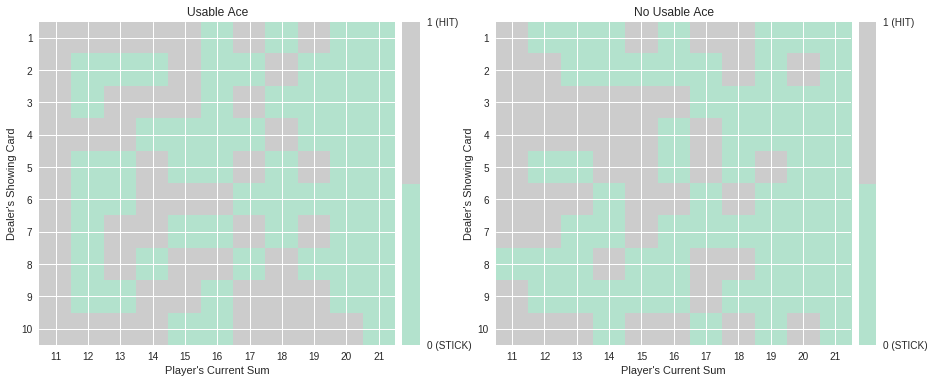

In [34]:
plot_policy(policy)